# Model selection and evaluation

__Notes__

1. Create set of rules for what reviews to accept or throw out
    1. Min or max number of words
    1. Include URLs or not
    1. Emojis
    1. Eliminate stop words
    
1. Model selection
    1. CNN for usefulness
    1. Sample from useful reviews only
    1. Setup T5 transfering learning model to generate "justification" text

- LSTM is good
    - You can add in an attention layer because it can look backwards and learn what words were more important than others
- CNN is good for sentence classification 
    - With a fully connected Dense layer it is not good at generalizing
- BERT is good because of its self-attention mechanism where every word looks at every other layer
    - Use the CLS token as the only thing you feed into the output layer that is going to make the prediction on the classification

## 0.0 Notebook setup

### X.X Colab Setup

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
! mkdir data

In [5]:
! cp "/content/gdrive/My Drive/nlp-book-reviews/data/review_samples.csv" ./data/

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12556231459336234201
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6052361959866108613
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [8]:
!pip install --quiet transformers

     |████████████████████████████████| 3.8 MB 3.9 MB/s 
     |████████████████████████████████| 6.5 MB 16.4 MB/s 
     |████████████████████████████████| 596 kB 32.7 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 895 kB 35.7 MB/s 


### X.X Local setup

In [9]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [10]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score

# Model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [11]:
# Local
# data = '../data/review_samples.csv'

# Colab
data = './data/review_samples.csv'

review_samples = pd.read_csv(data)

## X.X Usefulness language modeling

In [12]:
reviews = review_samples['reviewProcessed']
labels = review_samples['useful'].astype(int)
sentiment = ['Not Useful', 'Useful']

### X.X Baseline - Naive Bayes

In [157]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

In [158]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [162]:
# Evaluate model on dev data
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.9967154374440131 0.5559534467323187 0.5514771709937332


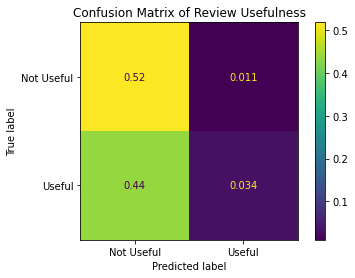

In [163]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### X.X Bi-directional LSTM

In [169]:
# Set tokenization parameters
num_words = None
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
# max_words = len(tokenizer.word_index)
# max_len = max([len(x) for x in sequences])
max_words = 5000
max_len = 125

# Pad review text tokens
reviews_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=max_len)

# Create usefulness target variable
labels = review_samples['useful']
labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")


In [170]:
(max_words, max_len)

(5000, 125)

In [171]:
# Set model hyperparamters
epochs = 10
batch_size = 32
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [172]:
# Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [122]:
y_test.shape

(1117, 2)

In [123]:
# Build model
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 40, input_length=max_len))
lstm_model.add(Bidirectional(LSTM(20, dropout=dropout_rate)))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(optimizer=opt, loss=loss, metrics=metrics)
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 125, 40)           200000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 2)                 82        
                                                                 
Total params: 209,842
Trainable params: 209,842
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Fit model
lstm_model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
105/105 - 6s - loss: 0.6853 - accuracy: 0.5497 - val_loss: 0.6803 - val_accuracy: 0.5560 - 6s/epoch - 56ms/step
Epoch 2/10
105/105 - 1s - loss: 0.6613 - accuracy: 0.6067 - val_loss: 0.6731 - val_accuracy: 0.5855 - 1s/epoch - 14ms/step
Epoch 3/10
105/105 - 1s - loss: 0.5976 - accuracy: 0.6901 - val_loss: 0.6842 - val_accuracy: 0.5936 - 1s/epoch - 14ms/step
Epoch 4/10
105/105 - 1s - loss: 0.4939 - accuracy: 0.7758 - val_loss: 0.7233 - val_accuracy: 0.5855 - 1s/epoch - 14ms/step
Epoch 5/10
105/105 - 1s - loss: 0.4395 - accuracy: 0.8074 - val_loss: 0.7868 - val_accuracy: 0.5900 - 1s/epoch - 14ms/step
Epoch 6/10
105/105 - 1s - loss: 0.3791 - accuracy: 0.8414 - val_loss: 0.9031 - val_accuracy: 0.5765 - 1s/epoch - 14ms/step
Epoch 7/10
105/105 - 1s - loss: 0.3503 - accuracy: 0.8504 - val_loss: 1.0050 - val_accuracy: 0.5810 - 1s/epoch - 14ms/step
Epoch 8/10
105/105 - 1s - loss: 0.3074 - accuracy: 0.8737 - val_loss: 0.9457 - val_accuracy: 0.5900 - 1s/epoch - 14ms/step
Epoch 9/10
105/1

In [125]:
# Evaluate model
lstm_model.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 0s 8ms/step - loss: 1.0912 - accuracy: 0.5542


[1.0912150144577026, 0.5541629195213318]

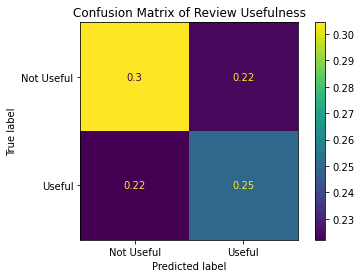

In [126]:
# Plot confusion matrix
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [127]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       590
           1       0.53      0.53      0.53       527

    accuracy                           0.55      1117
   macro avg       0.55      0.55      0.55      1117
weighted avg       0.55      0.55      0.55      1117



In [128]:
example0 = "Golf tips magazine is one of the most aptly titled magazines available today. \
            It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
            \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
            more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
            a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
            but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
            loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
            aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
            but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
            appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
            him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

example1 = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
            I just wish it came out more often!"

example2 = "this data science article is the best ever"

example3 = "i really loved how the technician helped me with the issue that i had"

example4 = "useless comment"

examples = [example0, example1, example2, example3, example4]

In [129]:
def test_examples(model, examples):
  for idx, example in enumerate(examples):
    sequence = tokenizer.texts_to_sequences([example])
    test = pad_sequences(sequence, maxlen=max_len)
    prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
    print(idx, ":", prediction)
    
test_examples(lstm_model, examples)

0 : Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X Convolutional neural network

In [173]:
# # Change data type from float to int
y_train = np.array([list(i).index(max(i)) for i in y_train])
y_dev = np.array([list(i).index(max(i)) for i in y_dev])
y_test = np.array([list(i).index(max(i)) for i in y_test])

# labels = review_samples['useful'].astype(int)
# X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
# X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [174]:
y_test.shape

(1117,)

In [175]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 32, input_length=max_len))
cnn_model.add(Conv1D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss, metrics=metrics)
cnn_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 125, 32)           160000    
                                                                 
 conv1d_9 (Conv1D)           (None, 125, 32)           3104      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 1984)              0         
                                                                 
 dense_23 (Dense)            (None, 250)               496250    
                                                                 
 dense_24 (Dense)            (None, 1)                 251       
                                                     

In [176]:
# Fit model
cnn_model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
105/105 - 1s - loss: 0.6783 - accuracy: 0.5796 - val_loss: 0.6801 - val_accuracy: 0.5551 - 1s/epoch - 12ms/step
Epoch 2/10
105/105 - 0s - loss: 0.5947 - accuracy: 0.6924 - val_loss: 0.6912 - val_accuracy: 0.5828 - 497ms/epoch - 5ms/step
Epoch 3/10
105/105 - 0s - loss: 0.2266 - accuracy: 0.9251 - val_loss: 0.9001 - val_accuracy: 0.5703 - 485ms/epoch - 5ms/step
Epoch 4/10
105/105 - 0s - loss: 0.0489 - accuracy: 0.9890 - val_loss: 1.1037 - val_accuracy: 0.5685 - 495ms/epoch - 5ms/step
Epoch 5/10
105/105 - 0s - loss: 0.0146 - accuracy: 0.9985 - val_loss: 1.2625 - val_accuracy: 0.5551 - 490ms/epoch - 5ms/step
Epoch 6/10
105/105 - 1s - loss: 0.0136 - accuracy: 0.9988 - val_loss: 1.4422 - val_accuracy: 0.5882 - 562ms/epoch - 5ms/step
Epoch 7/10
105/105 - 1s - loss: 0.0107 - accuracy: 0.9988 - val_loss: 1.7276 - val_accuracy: 0.5828 - 575ms/epoch - 5ms/step
Epoch 8/10
105/105 - 1s - loss: 0.0084 - accuracy: 0.9991 - val_loss: 1.4347 - val_accuracy: 0.5712 - 517ms/epoch - 5ms/step
Ep

In [134]:
# Evaluate model
cnn_model.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 0s 3ms/step - loss: 1.3591 - accuracy: 0.5792


[1.3591108322143555, 0.5792300701141357]

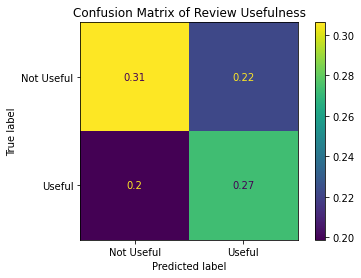

In [135]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [136]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59       590
           1       0.55      0.58      0.56       527

    accuracy                           0.58      1117
   macro avg       0.58      0.58      0.58      1117
weighted avg       0.58      0.58      0.58      1117



In [137]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT

In [148]:
# Download pre-trained BERT model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
X, y = review_samples['reviewProcessed'], review_samples['useful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

train = pd.DataFrame([X_train, y_train]).T
dev = pd.DataFrame([X_dev, y_dev]).T
test = pd.DataFrame([X_test, y_test]).T

In [140]:
def convert_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 
    examples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                 text_a = x[DATA_COLUMN], 
                                                 text_b = None,
                                                 label = x[LABEL_COLUMN]
                                                ),
                          axis = 1
                         )
  
    return examples


  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(e.text_a,
                                           add_special_tokens=True,
                                           max_length=max_length, # truncates if len(s) > max_length
                                           return_token_type_ids=True,
                                           return_attention_mask=True,
                                           pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
                                           truncation=True
                                          )

        input_ids = input_dict["input_ids"]
        token_type_ids = input_dict["token_type_ids"] 
        attention_mask = input_dict['attention_mask']

        features.append(InputFeatures(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      label=e.label
                                     )
                       )

    def gen():
        for f in features:
            yield ({"input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                   },
                   f.label,
                  )

    return tf.data.Dataset.from_generator(gen,
                                          ({"input_ids": tf.int32,
                                            "attention_mask": tf.int32,
                                            "token_type_ids": tf.int32
                                           },
                                           tf.int64
                                          ),
                                          ({"input_ids": tf.TensorShape([None]),
                                            "attention_mask": tf.TensorShape([None]),
                                            "token_type_ids": tf.TensorShape([None]),
                                           },
                                           tf.TensorShape([]),
                                          ),
                                         )




In [142]:
DATA_COLUMN = 'reviewProcessed'
LABEL_COLUMN = 'useful'


train_InputExamples = convert_data_to_examples(train, DATA_COLUMN, LABEL_COLUMN)
dev_InputExamples = convert_data_to_examples(dev, DATA_COLUMN, LABEL_COLUMN)
test_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

dev_data = convert_examples_to_tf_dataset(list(dev_InputExamples), bert_tokenizer)
dev_data = dev_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), bert_tokenizer)
test_data = test_data.batch(32)

In [178]:
# Reset certain hyperparameters
bert_opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
bert_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

In [179]:
# Build model
bert_model.compile(optimizer=bert_opt, 
                   loss=bert_loss, 
                   metrics=bert_metrics
                  )
bert_model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [180]:
%%time
# Fit model
bert_model.fit(train_data, validation_data=dev_data, epochs=2)
# bert_model.fit(X_train, y_train, epochs=2)

Epoch 1/2
210/210 [==============================] - 197s 848ms/step - loss: 0.7058 - accuracy: 0.5121 - val_loss: 0.6916 - val_accuracy: 0.5282
Epoch 2/2
210/210 [==============================] - 176s 836ms/step - loss: 0.7028 - accuracy: 0.5179 - val_loss: 0.6919 - val_accuracy: 0.5282
CPU times: user 3min 19s, sys: 1min 18s, total: 4min 37s
Wall time: 6min 38s


In [ ]:
# Evaluate model
bert_model.evaluate(test_data)

In [ ]:
test_data

In [ ]:
# Plot confusion matrix
y_true = test_data
y_pred = (bert_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
# test_sentence = "Golf tips magazine is one of the most aptly titled magazines available today. \
#                  It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
#                  \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
#                  more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
#                  a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
#                  but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
#                  loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
#                  aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
#                  but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
#                  appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
#                  him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

test_sentence = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
                 I just wish it came out more often!"

predict_input = bert_tokenizer.encode(test_sentence,
                                      truncation=True,
                                      padding=True,
                                      return_tensors="tf"
                                     )
tf_output = bert_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(sentiment[label[0]])

### X.X Tensorflow BERT demo
[BERT expert wiki_books/sst2](https://tfhub.dev/google/experts/bert/wiki_books/sst2/2)

In [183]:
!pip install --quiet tensorflow_text

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

# Define some sentences to feed into the model
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

# Load the BERT encoder and preprocessing models
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/wiki_books/sst2/2')

# Convert the sentences to bert inputs
bert_inputs = preprocess(sentences)

# Feed the inputs to the model to get the pooled and sequence outputs
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output']
sequence_output = bert_outputs['sequence_output']

print('\nSentences:')
print(sentences)
print('\nPooled output:')
print(pooled_output)
print('\nSequence output:')
print(sequence_output)

## X.X Tensflow BERT Demo II

[TF BERT Tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [15]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.7 MB/s 
     |████████████████████████████████| 462 kB 46.4 MB/s 


In [16]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 99 kB 5.5 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 237 kB 31.4 MB/s 
     |████████████████████████████████| 90 kB 5.5 MB/s 
     |████████████████████████████████| 352 kB 33.4 MB/s 
     |████████████████████████████████| 1.2 MB 22.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.0 MB/s 
     |████████████████████████████████| 47.8 MB 74 kB/s 


In [17]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [19]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 4s 0us/step


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [21]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [23]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [24]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [25]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [27]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626282   0.9928099  -0.18611862  0.3667383   0.15233758  0.655044
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842764 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946292  0.34321183  0.33231512 ...  0.21300802  0.7102092
  -0.05771042]
 [-0.28741995  0.31980985 -0.23018652 ...  0.5845511  -0.21329862
   0.72692007]
 [-0.6615692   0.68876815 -0.8743301  ...  0.1087728  -0.26173076
   0.47855455]
 ...
 [-0.22561137 -0.2892573  -0.07064426 ...  0.47566032  0.8327724
   0.40025347]
 [-0.2982421  -0.27473164 -0.05450544 ...  0.4884972   1.0955367
   0.18163365]
 [-0.4437818   0.00930662  0.07223704 ...  0.17290089  1.1833239
   0.07897975]]


In [28]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [29]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.8382415]], shape=(1, 1), dtype=float32)


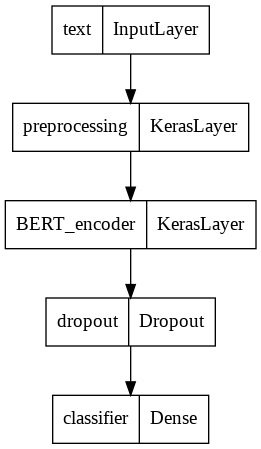

In [30]:
tf.keras.utils.plot_model(classifier_model)

In [31]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [32]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [33]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [35]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

### CNN setup from assignment 4

In [ ]:
# Specify model hyperparameters
epochs = 5
embed_dim = 5
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = [10, 4]
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))

# Construct the convolutional neural network.
# The form of each keras layer function is as follows:
#    result = keras.layers.LayerType(arguments for the layer)(layer(s) it should use as input)
# concretely,
#    this_layer_output = keras.layers.Dense(100, activation='relu')(prev_layer_vector)
# performs this_layer_output = relu(prev_layer_vector x W + b) where W has 100 columns.

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(max_words, embed_dim, input_length=max_len)(wordids)

# Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
# With the default hyperparameters, we construct 2 filters each of size 2, 3, 4.  As in the image above, each filter
# is wide enough to span the whole word embedding (this is why the convolution is "1d" as seen in the
# function name below).
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

# Concat the feature maps from each different size.
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='softmax')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.

In [ ]:
model.fit(X_train, y_train, epochs=epochs)

## X.X Explanation transfer learning

In [ ]:
# from transformers.models.t5 import T5Model
from transformers import TFT5Model

In [ ]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "max_seq_length": 128,
    "train_batch_size": 8,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "save_steps": -1,
    "use_multiprocessing": False,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "fp16": False,

    "wandb_project": "Question Generation with T5",
}

model = TFT5Model.from_pretrained("t5-small")

### X.X Pre-trained sentiment span extraction model

https://huggingface.co/mrm8488/t5-base-finetuned-span-sentiment-extraction

In [ ]:
example = review_samples.iloc[2]['reviewText']

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")

def get_sentiment_span(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

    generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

    predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return predicted_span
  
get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'

In [ ]:
get_sentiment_span("question: negative context: {}".format(example))

In [ ]:
review_samples.iloc[2]['reviewText']